# KAN on SAD dataset

This notebook contains all code needed to run the PyKAN library on the SAD dataset. The notebook might not be that easy to follow, I might yet work on that. I just ripped this out of the benchmarking-KAN/ files such that you can mess with all the individual parts.

In [2]:
import torch
import torch.utils
import numpy as np
import datetime
import pickle

from train.train import train_pykan
from utils.utils import count_parameters, compute_metrics
from pykan.kan import *
import pandas as pd
import numpy as np
import os
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from pykan.kan.spline import coef2curve  
import scipy.interpolate
import torch.nn.functional as F

import ipywidgets as widgets
from IPython.display import display, clear_output

## Constants

In [176]:
WITH_GRAPHS = True

# Shape of KAN model.
# The first number is how many inputs there are, 
#  the last is how many classes there are. 
KAN_SHAPE = [53, 1, 2] 

# This should pick your CPU if you dont have a GPU. 
# For some datasets training might be faster on CPU.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# Uncomment the line below to force training on CPU:
# device = 'cpu'

# Seed to initialize KAN model
SEED = 42
# Grid size for KAN model (default=5)
GRID = 5
# Number of control points in splines for KAN model (default=3) 
K = 3
# How many epochs to train for
NUM_EPOCHS = 10
# Colors
orange = '#faa63e'
blue = '#3685eb' 

## Data prep

In [4]:
data = pd.read_stata("data/MIMIC-IV.dta")

# These columns wont be used.
# This line also drops NA's
data = data.drop(
    [
        "deliriumtime",
        "hosp_mort",
        "icu28dmort",
        "stay_id",
        "icustay",
        "hospstay",
        "sepsistime",
    ],
    axis=1,
).dropna()

# Race and first_careunit will be separated into a new boolean 
#  column for each race or unit,
dummies = pd.get_dummies(data["race"])
data = data.drop("race", axis=1).join(dummies)
dummies = pd.get_dummies(data["first_careunit"])
data = data.drop("first_careunit", axis=1).join(dummies)

# Write out abreviations in full and add type of measurement.
data = data.rename(
    columns={
        "age": "Leeftijd",
        "weight": "Gewicht (Kg)",
        "gender": "Geslacht (Male)",
        "temperature": "Temperatuur (Celcius)",
        "heart_rate": "Hartslag (Slagen per Minuut)",
        "resp_rate": "Ademhalingsfrequentie",
        "sbp": "Systolische bloeddruk (mmHg)",
        "dbp": "Diastolische bloeddruk (mmHg)",
        "mbp": "Gemiddelde arteriële druk (mmHg)",
        "wbc": "Witte bloedcellen (K/uL)",
        "hemoglobin": "Hemoglobine (g/dL)",
        "platelet": "Bloedplaatjes (k/uL)",
        "bun": "BUN (mg/dL)",
        "cr": "Creatinine (mg/dL)",
        "glu": "Glucose (mg/dL)",
        "Na": "Natrium (mEq/L)",
        "Cl": "Chloride (mEq/L)",
        "K": "Kalium (mEq/L)",
        "Mg": "Magnesium (mg/dL)",
        "Ca": "Totale calcium (mg/dL)",
        "P": "Fosfaat (mg/dL)",
        "inr": "INR",
        "pt": "Protrombinetijd (s)",
        "ptt": "PTT (s)",
        "bicarbonate": "Bicarbonaat (mEq/L)",
        "aniongap": "Anion gap (mEq/L)",
        "gcs": "GCS",
        "vent": "Mechanische ventilatie n (%)",
        "crrt": "CRRT n (%)",
        "vaso": "Vasopressor n (%)",
        "seda": "Sedatie n (%)",
        "sofa_score": "SOFA",
        "ami": "AMI n (%)",
        "ckd": "CKD n (%)",
        "copd": "COPD n (%)",
        "hyperte": "Hypertensie n (%)",
        "dm": "Diabetes n (%)",
        "sad": "SAD",
        "aki": "AKI n (%)",
        "stroke": "Beroerte n (%)",
        "AISAN": "Ras: Aziatisch",
        "BLACK": "Ras: Afrikaans",
        "HISPANIC": "Race: Latijn-amerikaans",
        "OTHER": "Race: Anders",
        "WHITE": "Race: Wit",
        "unknown": "Race: Onbekend",
        "CCU": "ICU Type: CCU",
        "CVICU": "ICU Type: CVICU",
        "MICU": "ICU Type: MICU",
        "MICU/SICU": "ICU Type: MICU/SICU",
        "NICU": "ICU Type: NICU",
        "SICU": "ICU Type: SICU",
        "TSICU": "ICU Type: TSICU"
    }
)

# The SAD column is the target.
x = data.drop("SAD", axis=1).values
y = data["SAD"].values

# continuous features
continuous_indices = [
    0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 
    15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26
]

# gcs: 27 and sofa score: 32
ordinal_indices = [27, 32]

# binary features
binary_indices = [
    2, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 
    41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52
]

# Label encode continuous data
continuous_data = x[:, continuous_indices].astype(np.float32)
scaler = MinMaxScaler()
normalized_continuous_data = scaler.fit_transform(continuous_data)

# Label encode ordinal data (use min-max scaling for now, 
#  potentially use one-hot encoding) 
#  - same as race and first_careunit
ordinal_data = x[:, ordinal_indices]
ordinal_encoder = MinMaxScaler()
encoded_ordinal_data = ordinal_encoder.fit_transform(ordinal_data)

# Label encode binary data
binary_data = x[:, binary_indices]
label_encoders = [LabelEncoder() for _ in binary_indices]
encoded_categorical_data = np.array(
    [
        le.fit_transform(binary_data[:, i]) 
        for i, le in enumerate(label_encoders)
    ]
).T

encoded_categorical_data = encoded_categorical_data.astype(np.int64)

# Combine continuous and encoded categorical data
processed_data = np.hstack((
    normalized_continuous_data, 
    encoded_categorical_data, 
    encoded_ordinal_data
))

X_train, X_test, y_train, y_test, train_indices, test_indices = \
    train_test_split(
        processed_data, 
        y, 
        np.arange(len(data)), 
        random_state=42, 
        test_size=0.3, 
        stratify=y
    )

# Keep a copy of the original data, 
# but put it in the same order as the processed data.
data_columns = list(data.drop("SAD", axis=1).columns.values)
continuous_labels = [data_columns[i] for i in continuous_indices]
binary_labels = [data_columns[i] for i in binary_indices]
ordinal_labels = [data_columns[i] for i in ordinal_indices]
data = data[[
    *continuous_labels, 
    *binary_labels, 
    *ordinal_labels, 
    "SAD"
]]
original_data = data.copy()  

# Convert the numpy arrays to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Dataloader for training and testing 
train_data = torch.utils.data.TensorDataset(X_train, y_train)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
test_loader = DataLoader(
    test_data, 
    batch_size=len(test_data), 
    shuffle=False
)

shape_dataset = X_train.shape[1]

dataset = {
    "train_input" : X_train, 
    "train_label" : y_train, 
    "test_input" : X_test, 
    "test_label" : y_test
}

## Training the model

	checkpoint directory created: ./model
	saving model version 0.0
experiment: PyKAN  | dataset=SAD | KAN shape=[[53, 0], [1, 0], [2, 0]]


| train_loss: 7.29e-01 | test_loss: 7.43e-01 | reg: 2.75e+01 | : 100%|█| 10/10 [00:39<00:00,  3.94s/


	saving model version 0.1

done training

	saving model version 0.2


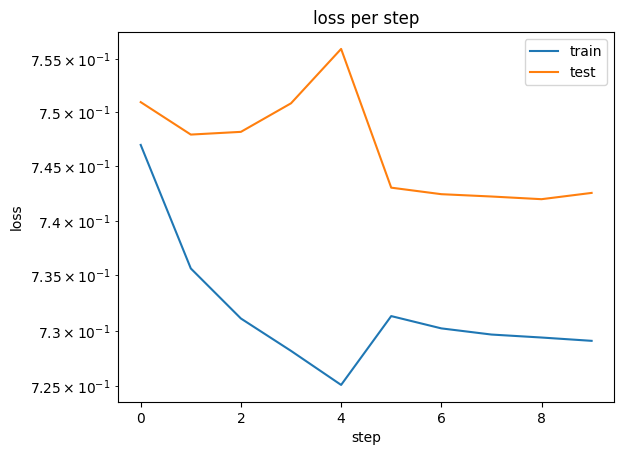

<Figure size 640x480 with 0 Axes>

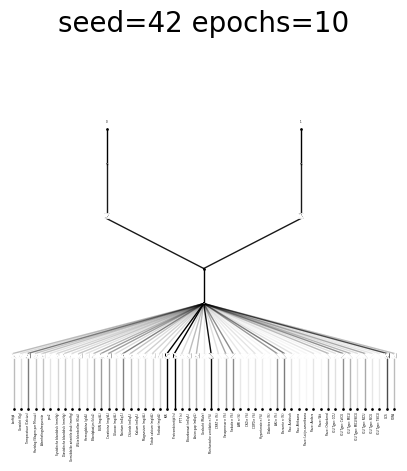

nodes = [[1, 0]]
training_time_per_epoch = 3.9411181449890136
parameters = 770
papi_results = None
test_accuracies = 72.64066686513844
test_f1 = 70.84323943961293
test_precision_scores = 71.56546249165442
test_recall_scores = 70.4959541833611
test_fpr = 18.799603174603174
test_fnr = 40.20848845867461
TN = 1637
FP = 379
FN = 540
TP = 803


In [5]:
#create output folder for the plots etc.
if WITH_GRAPHS:
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%Hh%M')
    if (not os.path.exists(f"output/SAD/{timestamp}")):
        os.makedirs(f"output/SAD/{timestamp}")
        os.mkdir(f"output/SAD/{timestamp}/train-test-loss")
        os.mkdir(f"output/SAD/{timestamp}/network-plots")

nodes = None
training_time_per_epoch = None
parameters = None
papi_results = None
test_accuracies = None
test_f1 = None
test_precision_scores = None
test_recall_scores = None
test_fpr = None
test_fnr = None

# send training data to device
for key, value in dataset.items():
    dataset[key] = value.to(DEVICE)
    # Create KAN model 
model = KAN(
    width=KAN_SHAPE, 
    grid=GRID,
    k=K, 
    seed=SEED, 
    device=DEVICE,
    sparse_init=True
)

# Train the pykan model
timings, results = train_pykan(
    epochs=NUM_EPOCHS, 
    model=model, 
    dataset=dataset,
    experiment=f"\033[32mPyKAN  | dataset=SAD | KAN shape="
        f"{KAN_SHAPE}\033[37m"
)
print('\ndone training\n')

model.prune()

#################################
#          save graphs          #
#################################

if WITH_GRAPHS:
    # plot the loss over time.
    plt.clf()
    plt.plot(results['train_loss'])
    plt.plot(results['test_loss'])
    plt.legend(['train', 'test'])
    plt.title("loss per step")
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.yscale('log')
    plt.savefig(
        f"output/SAD/{timestamp}/train-test-loss/"
        f"seed={SEED}_epochs={NUM_EPOCHS}.png"
    )

    plt.show()
    plt.clf()

    # Plot the Pykan model.
    model.plot(
        folder=f"output/SAD/{timestamp}/network-plots/"
            f"loose-plots_seed={SEED}_epochs={NUM_EPOCHS}/", 
        tick=True,
        in_vars=list(original_data.drop("SAD", axis=1).columns),
        out_vars=list(range(0, 2)),
        varscale=0.1,
        title=f"seed={SEED} epochs={NUM_EPOCHS}", 
        unnormalised_DataFrame=original_data
    )
    # Save the plot with a very high dpi (dots per inch).
    # This makes really big output images, 
    #  which keeps you able to zoom in.
    plt.savefig(
        f"output/SAD/{timestamp}/network-plots/"
            f"seed={SEED}_epochs={NUM_EPOCHS}.png", 
        dpi=4000
    )
    plt.show()

    #################################
    #       Calculate metrics       #
    #################################

    # timings defined in `train_pykan`
    training_time_per_epoch = timings

    # Count and save how many nodes were used.
    nodes = KAN_SHAPE[1:-1]

    # Count and save how many parameters that is.
    parameters = count_parameters(model)

    # We need to change the device to cpu for the sake of efficiency.
    test_device = 'cpu'
    model.to(test_device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        data = dataset["test_input"].to(test_device)
        target = dataset["test_label"].to(test_device)

        output = model(data)
        
        total += target.size(0)
        
        # Use torch.argmax to find the predicted class.
        correct += (output.argmax(1) == target).sum().item()

        t_f1, test_precision, test_recall, FPR, FNR, TN, FP, FN, TP = compute_metrics(
            target=target, 
            output=output, 
            average='macro')
        
        # Convert all to percentages before saving.
        test_f1 = t_f1*100
        test_precision_scores = test_precision*100
        test_recall_scores = test_recall*100
        test_fpr = FPR*100
        test_fnr = FNR*100

    test_acc = correct / total * 100
    test_accuracies = test_acc

# nicer formatting for this print can be found in utils/utils.py
print(f"{nodes = }\n{training_time_per_epoch = }\n{parameters = }\n{papi_results = }\n{test_accuracies = }\n{test_f1 = }\n{test_precision_scores = }\n{test_recall_scores = }\n{test_fpr = }\n{test_fnr = }\n{TN = }\n{FP = }\n{FN = }\n{TP = }")

# Save the activation function information
model.save_act = True

In [39]:
torch.save({'model_state_dict': model.state_dict(), 
            'feature_scores': model.feature_score,
            'model_spline_preacts': model.spline_preacts,
            'model_spline_postacts': model.spline_postacts}, 
            'model_with_scores.pt')

In [5]:
model = KAN(width=[53, 1, 2], grid=5, k=3, seed=42)

	checkpoint directory created: ./model
	saving model version 0.0


# Load Model

In [6]:
# Load the saved dictionary
checkpoint = torch.load('model_with_scores.pt')

# Load the model weights
model.load_state_dict(checkpoint['model_state_dict'])

# Assign additional attributes
model.feature_scores = checkpoint['feature_scores']
model.spline_preacts = checkpoint['model_spline_preacts']
model.spline_postacts = checkpoint['model_spline_postacts']

model.eval()

with open('models/original_df.pkl', 'rb') as file:
    original_data = pickle.load(file)

In [7]:
model.feature_scores

tensor([0.0902, 0.0462, 0.1894, 0.0755, 0.0787, 0.0360, 0.0548, 0.0676, 0.0449,
        0.0764, 0.0398, 0.0955, 0.1352, 0.1304, 0.0485, 0.1787, 0.0814, 0.0434,
        0.0622, 0.0564, 0.0526, 0.9952, 1.0264, 0.0519, 0.0890, 0.0963, 0.0312,
        0.5827, 0.0403, 0.1179, 0.1626, 0.0295, 0.0264, 0.0352, 0.0265, 0.0132,
        0.1396, 0.1900, 0.0399, 0.0165, 0.0123, 0.0337, 0.0134, 0.0931, 0.0414,
        0.1557, 0.1010, 0.0438, 0.1164, 0.0330, 0.0270, 0.2912, 0.0898],
       requires_grad=True)

In [41]:
""" 
import os
import datetime
import matplotlib.pyplot as plt
import torch

# Define the hidden node configurations to test
hidden_node_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Dictionary to collect results
performance_results = {
    "num_nodes": [],
    "accuracy": [],
    "f1": [],
    "precision": [],
    "recall": [],
    "fpr": [],
    "fnr": [],
    "parameters": [],
    "training_time_per_epoch": []
}

# Create global output folder
global_timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%Hh%M')
output_base = f"output/SAD/{global_timestamp}"
os.makedirs(output_base, exist_ok=True)

for num_hidden_nodes in hidden_node_options:
    # Define KAN shape: [input_dim, hidden, output_dim]
    input_dim = dataset["train_input"].shape[1]
    output_dim = 2
    KAN_SHAPE = [input_dim, num_hidden_nodes, output_dim]

    if WITH_GRAPHS:
        run_path = f"{output_base}/nodes={num_hidden_nodes}"
        os.makedirs(f"{run_path}/train-test-loss", exist_ok=True)
        os.makedirs(f"{run_path}/network-plots", exist_ok=True)

    # Reset variables
    nodes = None
    training_time_per_epoch = None
    parameters = None
    papi_results = None
    test_accuracies = None
    test_f1 = None
    test_precision_scores = None
    test_recall_scores = None
    test_fpr = None
    test_fnr = None

    # Move dataset to device
    for key, value in dataset.items():
        dataset[key] = value.to(DEVICE)

    # Create and train model
    model = KAN(
        width=KAN_SHAPE,
        grid=GRID,
        k=K,
        seed=SEED,
        device=DEVICE,
        sparse_init=True
    )

    timings, results = train_pykan(
        epochs=NUM_EPOCHS,
        model=model,
        dataset=dataset,
        experiment=f"\033[32mPyKAN | nodes={num_hidden_nodes} | shape={KAN_SHAPE}\033[37m"
    )
    print(f'\nFinished training for {num_hidden_nodes} hidden nodes\n')

    model = model.prune()

    if WITH_GRAPHS:
        # Plot loss
        plt.clf()
        plt.plot(results['train_loss'])
        plt.plot(results['test_loss'])
        plt.legend(['train', 'test'])
        plt.title("Loss per Step")
        plt.ylabel('Loss')
        plt.xlabel('Step')
        plt.yscale('log')
        plt.savefig(f"{run_path}/train-test-loss/seed={SEED}_epochs={NUM_EPOCHS}.png")
        plt.show()
        plt.clf()

        # Plot network
        model.plot(
            folder=f"{run_path}/network-plots/loose-plots_seed={SEED}_epochs={NUM_EPOCHS}/",
            tick=True,
            in_vars=list(original_data.drop("SAD", axis=1).columns),
            out_vars=list(range(0, 2)),
            varscale=0.1,
            title=f"seed={SEED} epochs={NUM_EPOCHS}",
            unnormalised_DataFrame=original_data
        )
        plt.savefig(f"{run_path}/network-plots/seed={SEED}_epochs={NUM_EPOCHS}.png", dpi=4000)
        plt.show()

        # Evaluation
        training_time_per_epoch = timings
        nodes = KAN_SHAPE[1:-1]
        parameters = count_parameters(model)

        model.to("cpu")
        model.eval()

        with torch.no_grad():
            data = dataset["test_input"].to("cpu")
            target = dataset["test_label"].to("cpu")
            output = model(data)

            correct = (output.argmax(1) == target).sum().item()
            total = target.size(0)

            t_f1, test_precision, test_recall, FPR, FNR = compute_metrics(
                target=target,
                output=output,
                average='macro'
            )

            test_accuracies = correct / total * 100
            test_f1 = t_f1 * 100
            test_precision_scores = test_precision * 100
            test_recall_scores = test_recall * 100
            test_fpr = FPR * 100
            test_fnr = FNR * 100

        # Collect metrics
        performance_results["num_nodes"].append(num_hidden_nodes)
        performance_results["accuracy"].append(test_accuracies)
        performance_results["f1"].append(test_f1)
        performance_results["precision"].append(test_precision_scores)
        performance_results["recall"].append(test_recall_scores)
        performance_results["fpr"].append(test_fpr)
        performance_results["fnr"].append(test_fnr)
        performance_results["parameters"].append(parameters)
        performance_results["training_time_per_epoch"].append(training_time_per_epoch)

        # Print results
        print(f"[{num_hidden_nodes} nodes] {nodes = }\n{training_time_per_epoch = }\n"
              f"{parameters = }\n{test_accuracies = }\n{test_f1 = }\n"
              f"{test_precision_scores = }\n{test_recall_scores = }\n"
              f"{test_fpr = }\n{test_fnr = }\n")

    # Save the activation function info
    model.save_act = True

# Plot Accuracy vs. Number of Nodes
plt.figure()
plt.plot(performance_results["num_nodes"], performance_results["accuracy"], marker='o')
plt.title("Test Accuracy vs. Number of Hidden Nodes")
plt.xlabel("Number of Hidden Nodes")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.savefig(f"{output_base}/accuracy_vs_nodes.png")
plt.show()
"""

' \nimport os\nimport datetime\nimport matplotlib.pyplot as plt\nimport torch\n\n# Define the hidden node configurations to test\nhidden_node_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]\n\n# Dictionary to collect results\nperformance_results = {\n    "num_nodes": [],\n    "accuracy": [],\n    "f1": [],\n    "precision": [],\n    "recall": [],\n    "fpr": [],\n    "fnr": [],\n    "parameters": [],\n    "training_time_per_epoch": []\n}\n\n# Create global output folder\nglobal_timestamp = datetime.datetime.now().strftime(\'%Y-%m-%d_%Hh%M\')\noutput_base = f"output/SAD/{global_timestamp}"\nos.makedirs(output_base, exist_ok=True)\n\nfor num_hidden_nodes in hidden_node_options:\n    # Define KAN shape: [input_dim, hidden, output_dim]\n    input_dim = dataset["train_input"].shape[1]\n    output_dim = 2\n    KAN_SHAPE = [input_dim, num_hidden_nodes, output_dim]\n\n    if WITH_GRAPHS:\n        run_path = f"{output_base}/nodes={num_hidden_nodes}"\n        os.makedirs(f"{run_path}/train-test-loss",

In [8]:
original_data = pd.read_pickle('models/original_df.pkl')

In [9]:
cached_preacts = model.spline_preacts
cached_postacts = model.spline_postacts

In [10]:
test_data = dataset["test_input"]

# Interpretability

In [11]:
# Reset the indices to the new values after sorting
continuous_indices = list(range(26))
binary_indices = list(range(26,51))
ordinal_indices = list(range(51, 53))

In [12]:
def get_feature_min_max(original_df, continuous_indices, binary_indices, ordinal_indices):
    """
    Returns a dictionary mapping feature index in processed_data to (min, max).
    """
    min_max_map = {}
    processed_index = 0

    # Continuous features
    for orig_idx in continuous_indices:
        col = original_df.columns[orig_idx]
        col_min = original_df[col].min()
        col_max = original_df[col].max()
        min_max_map[processed_index] = (col_min, col_max)
        processed_index += 1

    # Binary features (fixed range 0 to 1)
    for _ in binary_indices:
        min_max_map[processed_index] = (0, 1)
        processed_index += 1

    # Ordinal features
    for orig_idx in ordinal_indices:
        col = original_df.columns[orig_idx]
        col_min = original_df[col].min()
        col_max = original_df[col].max()
        min_max_map[processed_index] = (col_min, col_max)
        processed_index += 1

    return min_max_map


In [13]:
test = get_feature_min_max(original_data, continuous_indices, binary_indices, ordinal_indices)

In [14]:
test_data[0]

tensor([0.1294, 0.1288, 0.4533, 0.5679, 0.4222, 1.0000, 0.3262, 0.3140, 0.3012,
        0.3023, 0.2667, 0.2121, 0.0470, 0.0251, 0.1736, 0.5568, 0.7073, 0.3151,
        0.1231, 0.3077, 0.1507, 0.0659, 0.0657, 0.1124, 0.3478, 0.0870, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000])

In [15]:
model.spline_postacts[0]

tensor([[[-0.0162, -0.0614,  0.4565,  ..., -0.0563,  0.1678,  0.1819]],

        [[-0.0577, -0.0627,  0.3275,  ..., -0.0140,  0.1678,  0.1585]],

        [[-0.0562, -0.0379,  0.3275,  ..., -0.0563,  0.1678,  0.1819]],

        ...,

        [[-0.0586, -0.0449,  0.2342,  ..., -0.0563,  0.1678,  0.1667]],

        [[-0.0656, -0.0601,  0.3170,  ..., -0.0140,  0.1678,  0.1819]],

        [[-0.1162, -0.0817,  0.3665,  ..., -0.0563,  0.1678,  0.1561]]])

In [16]:
# Get feature min-max values
feature_bounds = get_feature_min_max(original_data, continuous_indices, binary_indices, ordinal_indices)

# Test

In [17]:
def explain_spline_minmax(
    model, l, i, j, feature_min, feature_max,
    x_norm_val=None, title=None, feature_names=None,
    save_dir=None
):

    x_norm = cached_preacts[l][:, j, i].detach().cpu().numpy()
    y_vals = cached_postacts[l][:, j, i].detach().cpu().numpy()

    x_real_vals = x_norm * (feature_max - feature_min) + feature_min
    sorted_idx = np.argsort(x_real_vals)
    x_real_vals = x_real_vals[sorted_idx]
    y_vals = y_vals[sorted_idx]

    # Use the feature name if provided, else fallback to index
    feature_label = feature_names[i] if feature_names is not None and i < len(feature_names) else f"Feature {i}"

    plt.figure(figsize=(8, 5))

    # Fill area above y = 0 with gray
    plt.axhspan(0, max(y_vals.max(), 0), color='lightgray', alpha=0.5)

    # Draw horizontal line at y = 0
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    # Plot each spline segment with color based on sign
    for k in range(len(x_real_vals) - 1):
        x0, x1 = x_real_vals[k], x_real_vals[k + 1]
        y0, y1 = y_vals[k], y_vals[k + 1]

        if y0 >= 0 and y1 >= 0:
            plt.plot([x0, x1], [y0, y1], color=blue)
        elif y0 < 0 and y1 < 0:
            plt.plot([x0, x1], [y0, y1], color=orange)
        else:
            # Interpolate zero crossing
            zero_x = x0 + (0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < 0:
                plt.plot([x0, zero_x], [y0, 0], color=orange)
                plt.plot([zero_x, x1], [0, y1], color=blue)
            else:
                plt.plot([x0, zero_x], [y0, 0], color=blue)
                plt.plot([zero_x, x1], [0, y1], color=orange)

    # Plot dots at data points, color-coded by sign
    for x, y in zip(x_real_vals, y_vals):
        color = blue if y >= 0 else orange
        plt.plot(x, y, 'o', color=color, markersize=4)

    # Optional: vertical line and red dot for current input value
    if x_norm_val is not None:
        x_real = x_norm_val * (feature_max - feature_min) + feature_min
        plt.axvline(x_real, color='red', linestyle='--', label=f'{feature_label} = {x_real:.2f}')
        if np.min(x_real_vals) <= x_real <= np.max(x_real_vals):
            y_at_x_real = np.interp(x_real, x_real_vals, y_vals)
            plt.plot(x_real, y_at_x_real, 'ro')
            plt.text(
                x_real, y_at_x_real,
                f"{y_at_x_real:.4f}",
                fontsize=9,
                ha='left',
                va='bottom',
                color='red',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.7)
            )
            print(f"At {feature_label} = {x_real:.2f}, Activation output = {y_at_x_real:.4f}")
        else:
            print(f"x = {x_real:.2f} is outside the spline range.")

    plt.xlabel(f"{feature_label}")
    plt.ylabel("Activation output")
    plt.title(title or f"Invloed van {feature_label} op het advies")
    plt.legend()
    plt.grid(True)

    # Save the plot if a directory is provided
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"layer{l}_input{i}_to_output{j}.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Saved plot to {filepath}")

    plt.show()

In [ ]:
# Loop through features and generate/save plots
for f_index in range(len(original_data.columns.tolist()) - 1):
    f_min, f_max = feature_bounds[f_index]
    explain_spline_minmax(
        model,
        l=0,
        i=f_index,
        j=0,
        feature_min=f_min,
        feature_max=f_max,
        feature_names=original_data.columns.tolist(),
        save_dir='static/splines'
    )

In [184]:
def explain_spline_output(
    model, l, i, title="Advies uitkomst", feature_names=None,
    save_dir="static/local_splines", combined=None
):
    # Extract activations for both classes
    x0 = cached_preacts[l][:, 0, i].detach().cpu().numpy()
    y0 = cached_postacts[l][:, 0, i].detach().cpu().numpy()

    x1 = cached_preacts[l][:, 1, i].detach().cpu().numpy()
    y1 = cached_postacts[l][:, 1, i].detach().cpu().numpy()

    # Sort both on x-values
    sort_idx = np.argsort(x0)
    x_vals = x0[sort_idx]
    y0 = y0[sort_idx]
    y1 = y1[sort_idx]  # Assume x0 == x1 due to shared inputs

    # Decision boundary: where the curves intersect
    diff = y0 - y1
    sign_change = np.where(np.diff(np.sign(diff)))[0]

    x_flip = None
    if len(sign_change) > 0:
        idx = sign_change[0]
        x_flip = np.interp(0, [diff[idx], diff[idx + 1]], [x_vals[idx], x_vals[idx + 1]])

    # Create directory
    os.makedirs(save_dir, exist_ok=True)

    # Plot both curves
    plt.figure()
    plt.plot(x_vals, y0, label='Geen SAD')
    plt.plot(x_vals, y1, label='SAD')

    # Plot decision boundary
    if x_flip is not None:
        plt.axvline(x=x_flip, color='red', linestyle='dashed', label=f'Beslissingsgrens: {x_flip:.4f}')

    # Plot combined input if provided
    if combined is not None:
        combined_val = float(combined)  # Ensure scalar
        plt.axvline(x=combined_val, color='purple', linestyle='dotted', label=f'Inputwaarde: {combined_val:.4f}')

        # Interpolate y values on both curves
        y0_interp = np.interp(combined_val, x_vals, y0)
        y1_interp = np.interp(combined_val, x_vals, y1)

        # Plot intersection points
        plt.scatter([combined_val], [y0_interp], color=blue)
        plt.scatter([combined_val], [y1_interp], color=orange)

        # Annotate the y-values
        plt.text(combined_val, y0_interp, f'{y0_interp:.2f}', color=blue, va='bottom', ha='right')
        plt.text(combined_val, y1_interp, f'{y1_interp:.2f}', color=orange, va='top', ha='right')

    plt.xlabel('Som Activatie Functies Outputs')
    plt.ylabel('Ruwe Uitkomst Model')
    plt.title(title)
    plt.legend()
    plt.grid(True)

    # Save
    filename = f"layer{l}_input{i}_adviesuitkomst.png"
    filepath = os.path.join(save_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Grafiek opgeslagen als: {filepath}")

In [173]:
explain_spline_output(model, 1,0)

Grafiek opgeslagen als: static/splines\layer1_input0_adviesuitkomst.png


# Manual Forward KAN

## Helper Functions

In [177]:
def get_layer_components(layer):
    return layer.grid, layer.coef, layer.scale_base, layer.scale_sp

def compute_spline_outputs(x_input, grid, coef, k, splineplots=False, layer_idx=0):
    spline_outputs = []
    for i in range(x_input.shape[1]):
        xi = x_input[:, [i]]
        grid_i = grid[i].unsqueeze(0)
        coef_i = coef[i].unsqueeze(0)

        spline_i = coef2curve(xi, grid_i, coef_i, k)[:, 0, 0]
        spline_outputs.append(spline_i)

        if splineplots:
            feature_bounds = get_feature_min_max(original_data, continuous_indices, binary_indices, ordinal_indices)
            f_min, f_max = feature_bounds[i]
            explain_spline_minmax(model, layer_idx, i, 0, f_min, f_max, x_norm_val=xi.item(), title=None, feature_names=original_data.columns.tolist()[:-1], save_dir="static/local_splines")

    return torch.stack(spline_outputs, dim=1)

def compute_combined_output(base_out, spline_out, scale_base, scale_sp):
    return scale_base.T * base_out + scale_sp.T * spline_out

def print_local_contributions(combined, base_out, spline_out, scale_base, scale_sp, feature_names):
    print(f"\nDetailed computation for patient:\n")

    contributions = []
    for j in range(len(feature_names)):
        sb = scale_base[j].item()
        ss = scale_sp[j].item()
        base_val = base_out[0, j].item()
        spline_val = spline_out[0, j].item()
        combined_val = combined[0, j].item()

        contributions.append((combined_val, feature_names[j], sb, base_val, ss, spline_val))

    # Sort by combined_val descending
    contributions.sort(reverse=True, key=lambda x: abs(x[0]))

    # Print sorted contributions
    for combined_val, name, sb, base_val, ss, spline_val in contributions:
        print(f"{name} = {sb:.4f} * {base_val:.4f} + {ss:.4f} * {spline_val:.4f} = {combined_val:.4f}")


def plot_local_feature_importance(contributions, feature_names, activation_flip_point=0.2361, sum_range=(-1.5, 1.7)):
    sad_color = orange
    geen_sad_color = blue

    # Sort features by absolute importance
    sorted_indices = np.argsort(np.abs(contributions))[::-1]
    sorted_contributions = contributions[sorted_indices]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    colors = [geen_sad_color if val >= 0 else sad_color for val in sorted_contributions]

    # Total sum of contributions
    total_sum = np.sum(contributions)
    epsilon = 1e-8
    is_geen_sad = total_sum > activation_flip_point + epsilon
    prediction = "Geen SAD" if is_geen_sad else "SAD"
    margin = activation_flip_point - total_sum
    margin_text = (
        f"Nog {margin:.3f} nodig voor Geen SAD" if not is_geen_sad
        else f"{abs(margin):.3f} boven de drempel"
    )

    # Create figure and layout
    fig = plt.figure(figsize=(10, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[1.2, 6])

    # === Top Plot: Activatiebalk tov drempel ===
    ax1 = fig.add_subplot(gs[0])
    x_min, x_max = sum_range
    ax1.set_xlim(x_min, x_max)

    # Background shading
    ax1.axvspan(x_min, activation_flip_point, color=sad_color, alpha=0.04, zorder=1)
    ax1.axvspan(activation_flip_point, x_max, color=geen_sad_color, alpha=0.04, zorder=1)

    # Decision threshold line
    ax1.axvline(activation_flip_point, color='red', linestyle='--', label=f"Drempel = {activation_flip_point:.4f}", zorder=2)

    # Draw bar from threshold to total_sum
    bar_color = geen_sad_color if is_geen_sad else sad_color
    if total_sum >= activation_flip_point:
        bar_start = activation_flip_point
        bar_width = total_sum - activation_flip_point
    else:
        bar_start = total_sum
        bar_width = activation_flip_point - total_sum
    ax1.barh(0, width=bar_width, left=bar_start, color=bar_color, height=0.2, zorder=3)

    # Clean look
    ax1.set_ylim(-0.6, 0.6)
    ax1.set_yticks([])
    ax1.spines['left'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Prediction and sum text
    ax1.set_title(f"Voorspelling: {prediction}  ({margin_text})",
                  fontsize=13, fontweight='bold',
                  color=blue if is_geen_sad else orange, pad=15)
    ax1.text(total_sum, 0.3, f"Som = {total_sum:.4f}", fontsize=9, ha='center', zorder=4)
    ax1.legend(loc='upper right')

    # === Bottom Plot: Lokale bijdragen ===
    ax2 = fig.add_subplot(gs[1])
    bars = ax2.barh(range(len(sorted_contributions)), np.abs(sorted_contributions), color=colors)
    ax2.set_yticks(range(len(sorted_feature_names)))
    ax2.set_yticklabels(sorted_feature_names)
    ax2.set_title("Belangrijkste bijdragen van patiëntkenmerken")
    ax2.axvline(0, color='black', linewidth=0.8)
    ax2.invert_yaxis()

    for i, bar in enumerate(bars):
        x_val = bar.get_width()
        sign = "+" if sorted_contributions[i] >= 0 else "-"
        ax2.text(x_val + 0.005, i, f"{sign}{x_val:.2f}", va='center', fontsize=8)

    plt.tight_layout()
    plt.show()
    
def compute_output_second_layer(layer_input, layer, base_fun, k):
    grid, coef, scale_base, scale_sp = get_layer_components(layer)
    spline_out = coef2curve(layer_input, grid, coef, k)[:, 0, :]
    base_out = base_fun(layer_input)
    return scale_base * base_out + scale_sp * spline_out

def denormalize_instance(normalized_tensor, scaler, ordinal_encoder, continuous_indices, ordinal_indices, binary_indices):
    """
    Reconstructs the full true feature vector from a normalized patient tensor, denormalizing continuous
    and ordinal features and keeping binary features unchanged.

    Parameters:
    - normalized_tensor (torch.Tensor): The normalized patient data (1D tensor).
    - scaler (MinMaxScaler): Fitted scaler for continuous features.
    - ordinal_encoder (MinMaxScaler): Fitted scaler for ordinal features.
    - continuous_indices (list): Indices of continuous features in full vector.
    - ordinal_indices (list): Indices of ordinal features in full vector.
    - binary_indices (list): Indices of binary features in full vector.

    Returns:
    - torch.Tensor: 1D tensor with all features in original (true) form.
    """
    if hasattr(normalized_tensor, "detach"):
        normalized_tensor = normalized_tensor.detach().cpu().numpy()
    
    # Prepare output array
    full_true_values = np.zeros_like(normalized_tensor)

    # Denormalize continuous
    continuous_normalized = normalized_tensor[continuous_indices].reshape(1, -1)
    full_true_values[continuous_indices] = scaler.inverse_transform(continuous_normalized).flatten()

    # Denormalize ordinal
    ordinal_normalized = normalized_tensor[ordinal_indices].reshape(1, -1)
    full_true_values[ordinal_indices] = ordinal_encoder.inverse_transform(ordinal_normalized).flatten()

    # Keep binary features unchanged
    full_true_values[binary_indices] = normalized_tensor[binary_indices]

    return torch.tensor(full_true_values, dtype=torch.float32)


## Main Manual Forward KAN

In [20]:
def manual_forward_kan(model, x_input, splineplots=False, detailed_computation=False):
    if x_input.dim() == 1:
        x_input = x_input.unsqueeze(0)

    feature_names = original_data.columns.tolist()[:-1] # Do not include SAD
    batch_size = x_input.shape[0]

    # First Layer
    layer1 = model.act_fun[0]
    grid1, coef1, scale_base1, scale_sp1 = get_layer_components(layer1)

    spline_out1 = compute_spline_outputs(x_input, grid1, coef1, model.k, splineplots, layer_idx=0)
    base_out1 = layer1.base_fun(x_input)
    combined1 = compute_combined_output(base_out1, spline_out1, scale_base1, scale_sp1)
    layer1_out = combined1.sum(dim=1, keepdim=True)

    if detailed_computation == True:
        print_local_contributions(combined1, base_out1, spline_out1, scale_base1, scale_sp1, feature_names)
    
    plot_local_feature_importance(combined1[0].detach().numpy(), feature_names)

    # Second Layer
    for j in range(model.width[2][0]):
        explain_spline_output(model, 1, 0, j, combined=layer1_out.detach().numpy())
    layer2 = model.act_fun[1]
    out = compute_output_second_layer(layer1_out, layer2, layer2.base_fun, model.k)

    print("Final output:", out)
    pred_class = torch.argmax(out, dim=1).item()
    print(f"Prediction: {pred_class}")

    return out, pred_class

In [21]:
patient1 = test_data[0]
patient1

tensor([0.1294, 0.1288, 0.4533, 0.5679, 0.4222, 1.0000, 0.3262, 0.3140, 0.3012,
        0.3023, 0.2667, 0.2121, 0.0470, 0.0251, 0.1736, 0.5568, 0.7073, 0.3151,
        0.1231, 0.3077, 0.1507, 0.0659, 0.0657, 0.1124, 0.3478, 0.0870, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000])

In [22]:
patient2 = test_data[1]
patient2

tensor([0.4941, 0.1310, 0.5806, 0.6543, 0.4667, 0.7600, 0.1872, 0.1105, 0.1205,
        0.1879, 0.4000, 0.2505, 0.0385, 0.0101, 0.1212, 0.5000, 0.4146, 0.2192,
        0.2308, 0.4692, 0.1370, 0.0220, 0.0287, 0.0802, 0.5870, 0.2391, 1.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0667])


Detailed computation for patient:

Protrombinetijd (s) = -0.0482 * 0.0146 + 1.2411 * -0.4267 = -0.5303
INR = 0.0694 * 0.0111 + 1.2043 * 0.3659 = 0.4414
Temperatuur (Celcius) = 0.3142 * 0.3723 + 1.3854 * 0.1520 = 0.3275
Mechanische ventilatie n (%) = -0.2521 * 0.0000 + 0.8628 * 0.2335 = 0.2015
GCS = -0.0735 * 0.7311 + 1.1518 * 0.1924 = 0.1678
SOFA = 0.0118 * 0.0344 + 1.0322 * 0.1532 = 0.1585
ICU Type: NICU = -0.1018 * 0.0000 + 0.9766 * 0.1389 = 0.1357
Beroerte n (%) = -0.1335 * 0.0000 + 0.9812 * 0.1363 = 0.1337
Magnesium (mg/dL) = 0.1518 * 0.1286 + 1.0482 * -0.1385 = -0.1256
AKI n (%) = -0.1594 * 0.7311 + 0.8175 * -0.0040 = -0.1198
Natrium (mEq/L) = -0.2407 * 0.3112 + 0.9280 * 0.1983 = 0.1092
spo2 = 0.1922 * 0.5178 + 0.9675 * 0.0083 = 0.1075
Creatinine (mg/dL) = 0.2317 * 0.0051 + 0.9504 * -0.1128 = -0.1060
Sedatie n (%) = -0.0135 * 0.0000 + 0.9609 * -0.1021 = -0.0981
Vasopressor n (%) = -0.0962 * 0.7311 + 0.9403 * -0.0262 = -0.0949
CRRT n (%) = 0.0478 * 0.0000 + 0.9950 * 0.0919 = 0.091

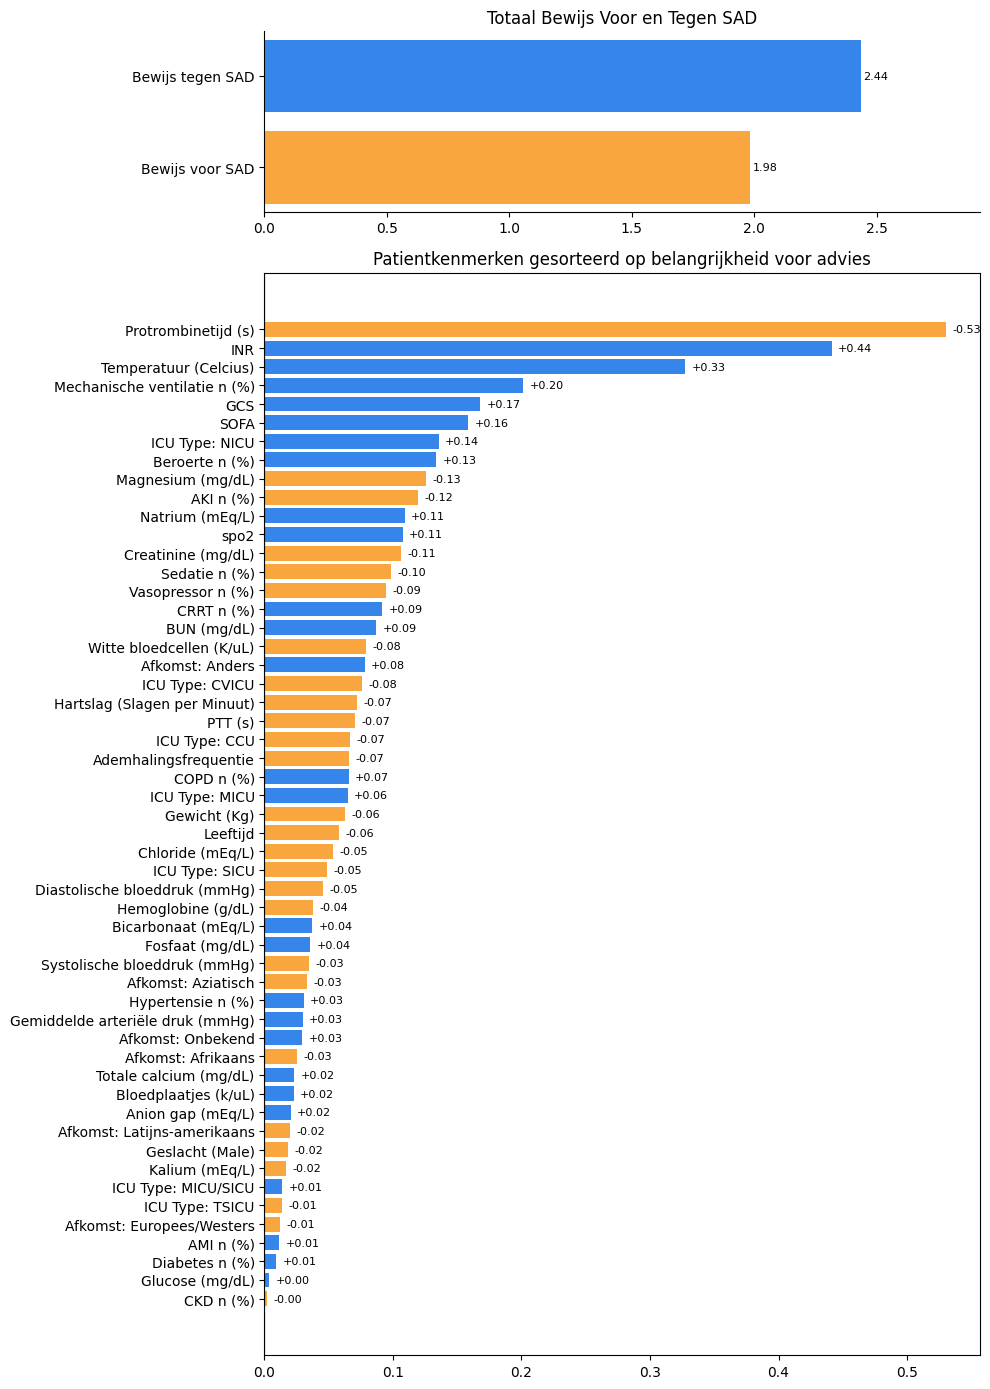

Waarde spline output op x=0.4507: 0.5096
Grafiek opgeslagen als: static/local_splines\layer1_input0_to_output0.png
Waarde spline output op x=0.4507: -0.2560
Grafiek opgeslagen als: static/local_splines\layer1_input0_to_output1.png
Final output: tensor([[ 0.5096, -0.2560]], grad_fn=<AddBackward0>)
Prediction: 0


(tensor([[ 0.5096, -0.2560]], grad_fn=<AddBackward0>), 0)

In [139]:
manual_forward_kan(model, patient2, detailed_computation=True)

# Explanations

# How (Global)

In [25]:
model.feature_scores

tensor([0.0902, 0.0462, 0.1894, 0.0755, 0.0787, 0.0360, 0.0548, 0.0676, 0.0449,
        0.0764, 0.0398, 0.0955, 0.1352, 0.1304, 0.0485, 0.1787, 0.0814, 0.0434,
        0.0622, 0.0564, 0.0526, 0.9952, 1.0264, 0.0519, 0.0890, 0.0963, 0.0312,
        0.5827, 0.0403, 0.1179, 0.1626, 0.0295, 0.0264, 0.0352, 0.0265, 0.0132,
        0.1396, 0.1900, 0.0399, 0.0165, 0.0123, 0.0337, 0.0134, 0.0931, 0.0414,
        0.1557, 0.1010, 0.0438, 0.1164, 0.0330, 0.0270, 0.2912, 0.0898],
       requires_grad=True)

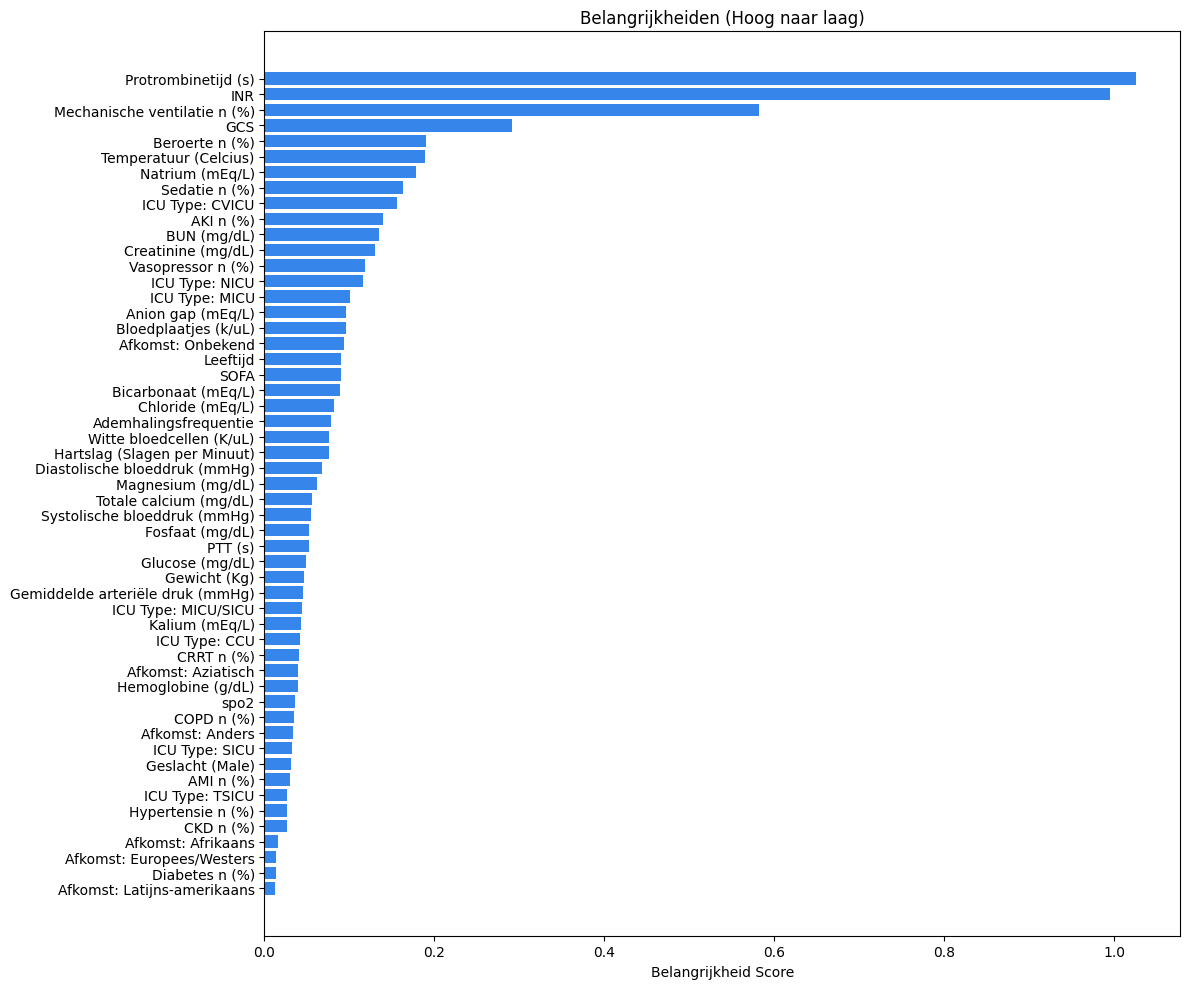

In [27]:
# Feature names
feature_names = original_data.columns.tolist()[:-1]

# Make a dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': model.feature_scores.detach().numpy()
})

# Sort by importance
importance_df = importance_df.sort_values(by='Score', ascending=False)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Score'], color = blue)
plt.xlabel('Belangrijkheid Score')
plt.title('Belangrijkheiden (Hoog naar laag)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## What Ifs

In [ ]:
def what_if_widget(
    normalized_tensor,
    manual_forward_kan,
    scaler,
    ordinal_encoder,
    continuous_indices,
    ordinal_indices,
    binary_indices,
    feature_names
):
    # Step 1: Denormalize input
    full_true_tensor = denormalize_instance(
        normalized_tensor,
        scaler,
        ordinal_encoder,
        continuous_indices,
        ordinal_indices,
        binary_indices
    )
    full_true_values = full_true_tensor.numpy()

    editable_indices = continuous_indices + ordinal_indices

    # Step 2: Compute contributions to determine slider order
    with torch.no_grad():
        layer = model.act_fun[0]
        grid, coef, scale_base, scale_sp = get_layer_components(layer)
        spline_out = compute_spline_outputs(normalized_tensor.unsqueeze(0), grid, coef, model.k)
        base_out = layer.base_fun(normalized_tensor.unsqueeze(0))
        combined = compute_combined_output(base_out, spline_out, scale_base, scale_sp)
        contributions = combined[0].detach().numpy()

    sorted_indices = sorted(editable_indices, key=lambda i: abs(contributions[i]), reverse=True)

    # Step 3: Build sliders (ordered by contribution)
    sliders = {}
    for i in sorted_indices:
        if i in continuous_indices:
            min_val = scaler.data_min_[continuous_indices.index(i)]
            max_val = scaler.data_max_[continuous_indices.index(i)]
            slider = widgets.FloatSlider(
                value=float(full_true_values[i]),
                min=float(min_val),
                max=float(max_val),
                step=0.1,
                description=feature_names[i],
                continuous_update=False,
                layout=widgets.Layout(width='60%'),
                style={'description_width': '200px'}
            )
        else:  # i in ordinal_indices
            min_val = ordinal_encoder.data_min_[ordinal_indices.index(i)]
            max_val = ordinal_encoder.data_max_[ordinal_indices.index(i)]
            slider = widgets.IntSlider(
                value=int(round(full_true_values[i])),
                min=int(round(min_val)),
                max=int(round(max_val)),
                step=1,
                description=feature_names[i],
                continuous_update=False,
                layout=widgets.Layout(width='60%'),
                style={'description_width': '200px'}
            )
        sliders[i] = slider

    # Step 4: Buttons and Output
    run_button = widgets.Button(description="Run What-If Analysis", button_style='primary')
    reset_button = widgets.Button(description="Reset Values", button_style='warning')
    output = widgets.Output()

    # Run What-If
    def on_run_click(b):
        modified_true = full_true_values.copy()
        for i, slider in sliders.items():
            modified_true[i] = slider.value

        # Re-normalize
        modified_norm = modified_true.copy()
        cont_vals = np.array([modified_true[i] for i in continuous_indices]).reshape(1, -1)
        ord_vals = np.array([modified_true[i] for i in ordinal_indices]).reshape(1, -1)

        modified_norm[continuous_indices] = scaler.transform(cont_vals).flatten()
        modified_norm[ordinal_indices] = ordinal_encoder.transform(ord_vals).flatten()

        modified_tensor = torch.tensor(modified_norm, dtype=torch.float32)

        with output:
            clear_output()
            print("Running What-If Analysis...")
            pred, _ = manual_forward_kan(model, modified_tensor.unsqueeze(0), detailed_computation=True)

    run_button.on_click(on_run_click)

    # Reset sliders to original values
    def on_reset_click(b):
        for i in sliders:
            sliders[i].value = float(full_true_values[i])

    reset_button.on_click(on_reset_click)

    # Step 5: Display UI
    slider_ui = widgets.VBox([sliders[i] for i in sorted_indices])
    button_row = widgets.HBox([run_button, reset_button])
    display(slider_ui, button_row, output)


In [ ]:
what_if_widget(
    data[1],  # normalized tensor for 1 patient
    manual_forward_kan=manual_forward_kan,  # your custom forward function
    scaler=scaler,
    ordinal_encoder=ordinal_encoder,
    continuous_indices=continuous_indices,
    ordinal_indices=ordinal_indices,
    binary_indices=binary_indices,
    feature_names=original_data.columns.tolist()[:-1]  
)


Output()

## Sensitivity

# Interactivity

In [28]:
from itertools import product

def generate_counterfactual_minimal(input_tensor, model, selected_features, scaler, ordinal_encoder,
                                     continuous_indices, binary_indices, ordinal_indices, steps_per_cont=100):
    input_tensor = input_tensor.clone().detach().to(model.device)
    model.eval()

    with torch.no_grad():
        original_pred = model(input_tensor.unsqueeze(0)).argmax(dim=1).item()

    # Build search space (sorted by distance from original input)
    search_space = []
    for idx in selected_features:
        orig_val = input_tensor[idx].item()

        if idx in continuous_indices:
            vals = np.linspace(0.0, 1.0, steps_per_cont)
            sorted_vals = sorted(vals, key=lambda x: abs(x - orig_val))
            search_space.append(sorted_vals)

        elif idx in binary_indices:
            current = int(round(orig_val))
            flipped = 1 - current
            search_space.append([flipped] if current != flipped else [current])

        elif idx in ordinal_indices:
            ordinal_search = []
            for i in range(len(ordinal_indices)):
                orig_min = ordinal_encoder.data_min_[i]
                orig_max = ordinal_encoder.data_max_[i]
                possible = np.arange(int(orig_min), int(orig_max) + 1).reshape(-1, 1)
                n_features = ordinal_encoder.transform(np.zeros((1, ordinal_encoder.n_features_in_))).shape[1]
                dummy = np.zeros((len(possible), n_features))
                dummy[:, i] = possible.flatten()
                normed = ordinal_encoder.transform(dummy)[:, i]
                ordinal_search.append(normed)

            vals = ordinal_search[ordinal_indices.index(idx)]
            sorted_vals = sorted(vals, key=lambda x: abs(x - orig_val))
            search_space.append(sorted_vals)

        else:
            raise ValueError(f"Unknown feature type for index {idx}")


    # Try all combinations of selected features
    for combination in product(*search_space):
        candidate_tensor = input_tensor.clone()
        for i, idx in enumerate(selected_features):
            candidate_tensor[idx] = torch.tensor(combination[i], dtype=torch.float32)

        with torch.no_grad():
            new_pred = model(candidate_tensor.unsqueeze(0)).argmax(dim=1).item()

        if new_pred != original_pred:
            # Found a counterfactual: try reverting each feature
            minimal_tensor = candidate_tensor.clone()
            for i, idx in enumerate(selected_features):
                # Try reverting feature i
                test_tensor = minimal_tensor.clone()
                test_tensor[idx] = input_tensor[idx]

                with torch.no_grad():
                    test_pred = model(test_tensor.unsqueeze(0)).argmax(dim=1).item()

                if test_pred == new_pred:
                    # Reverting did not undo the flip → change not needed
                    minimal_tensor[idx] = input_tensor[idx]

            # Final check: ensure result still flips
            final_pred = model(minimal_tensor.unsqueeze(0)).argmax(dim=1).item()
            if final_pred != original_pred:
                return minimal_tensor

    return None  # No counterfactual found


In [ ]:
# Pick a normalized input from your test set
patient_tensor = data[0]

# Choose the indices of features you allow to change
# 0 = Age, 27 = GCS (ordinal), for example
selected_features = [0,1]

# Call the minimal counterfactual generator
cf_tensor = generate_counterfactual_minimal(
    input_tensor=patient_tensor,
    model=model,
    selected_features=selected_features,
    scaler=scaler,
    ordinal_encoder=ordinal_encoder,
    continuous_indices=continuous_indices,
    binary_indices=binary_indices,
    ordinal_indices=ordinal_indices,
    steps_per_cont=50  # try 50 values for continuous features
)

# Display results
if cf_tensor is not None:
    print("✅ Counterfactual found!\n")
    
    changed_indices = [i for i in range(53) if not torch.allclose(cf_tensor[i], patient_tensor[i])]
    print("Changed feature indices:", changed_indices)
    
    for idx in changed_indices:
        print(f"Feature {idx}: {patient_tensor[idx].item():.3f} → {cf_tensor[idx].item():.3f}")
else:
    print("❌ No counterfactual found.")

c:\Users\FerroFast\KAN_workspace\benchmarking-KAN\pykan\kan\MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\FerroFast\KAN_workspace\benchmarking-KAN\pykan\kan\MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\FerroFast\KAN_workspace\benchmarking-KAN\pykan\kan\MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  output_

✅ Counterfactual found!

Changed feature indices: [0, 1]
Feature 0: 0.129 → 0.061
Feature 1: 0.129 → 1.000


In [140]:
manual_forward_kan(model, cf_tensor) 

NameError: name 'cf_tensor' is not defined

In [ ]:
logits = torch.tensor([[0.0731, 0.0697]])
probs = F.softmax(logits, dim=1)
print(probs)


# Add a small epsilon to avoid log(0)
eps = 1e-10
entropy = -torch.sum(probs * torch.log(probs + eps), dim=1)

print(f"Entropy: {entropy.item():.4f}")

tensor([[0.5009, 0.4992]])
Entropy: 0.6931


In [68]:
original_data.columns.tolist()

['Leeftijd',
 'Gewicht (Kg)',
 'Temperatuur (Celcius)',
 'Hartslag (Slagen per Minuut)',
 'Ademhalingsfrequentie',
 'spo2',
 'Systolische bloeddruk (mmHg)',
 'Diastolische bloeddruk (mmHg)',
 'Gemiddelde arteriële druk (mmHg)',
 'Witte bloedcellen (K/uL)',
 'Hemoglobine (g/dL)',
 'Bloedplaatjes (k/uL)',
 'BUN (mg/dL)',
 'Creatinine (mg/dL)',
 'Glucose (mg/dL)',
 'Natrium (mEq/L)',
 'Chloride (mEq/L)',
 'Kalium (mEq/L)',
 'Magnesium (mg/dL)',
 'Totale calcium (mg/dL)',
 'Fosfaat (mg/dL)',
 'INR',
 'Protrombinetijd (s)',
 'PTT (s)',
 'Bicarbonaat (mEq/L)',
 'Anion gap (mEq/L)',
 'Geslacht (Male)',
 'Mechanische ventilatie n (%)',
 'CRRT n (%)',
 'Vasopressor n (%)',
 'Sedatie n (%)',
 'AMI n (%)',
 'CKD n (%)',
 'COPD n (%)',
 'Hypertensie n (%)',
 'Diabetes n (%)',
 'AKI n (%)',
 'Beroerte n (%)',
 'Ras: Aziatisch',
 'Ras: Afrikaans',
 'Race: Latijn-amerikaans',
 'Race: Anders',
 'Race: Wit',
 'Race: Onbekend',
 'ICU Type: CCU',
 'ICU Type: CVICU',
 'ICU Type: MICU',
 'ICU Type: MICU/SI

## How to still be this

In [29]:
l = 1
i = 0

In [30]:
# 1. Get x-axis and both output curves
x_vals = cached_preacts[l][:, 0, i].detach().cpu().numpy()
x_sorted_idx = np.argsort(x_vals)
x_vals = x_vals[x_sorted_idx]

y0 = cached_postacts[l][:, 0, i].detach().cpu().numpy()[x_sorted_idx]  # Geen SAD
y1 = cached_postacts[l][:, 1, i].detach().cpu().numpy()[x_sorted_idx]  # SAD

# 2. Difference between outputs
diff = y0 - y1

# 3. Find where diff crosses zero
cross_indices = np.where(np.diff(np.sign(diff)))[0]
if len(cross_indices) > 0:
    idx = cross_indices[0]
    # Linear interpolation to estimate the crossing point
    x0, x1 = x_vals[idx], x_vals[idx + 1]
    y0_diff, y1_diff = diff[idx], diff[idx + 1]
    x_flip = x0 - y0_diff * (x1 - x0) / (y1_diff - y0_diff)
    print(f"Voorspelling wisselt bij Som Activatie Functies Output ≈ {x_flip:.4f}")
else:
    print("Geen omslagpunt gevonden binnen het bereik.")


Voorspelling wisselt bij Som Activatie Functies Output ≈ 0.2361


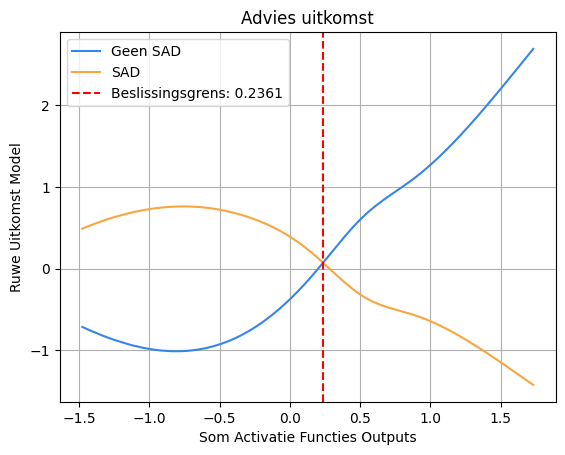

In [175]:
plt.plot(x_vals, y0, label='Geen SAD', color = blue)
plt.plot(x_vals, y1, label='SAD', color = orange)
plt.axvline(x=x_flip, color='red', linestyle='dashed', label=f'Beslissingsgrens: {x_flip:.4f}')
plt.xlabel('Som Activatie Functies Outputs')
plt.ylabel('Ruwe Uitkomst Model')
plt.title('Advies uitkomst')
plt.legend()
plt.grid(True)
plt.savefig('static/splines/advies_uitkomst_plot.png', dpi=300, bbox_inches='tight')
plt.show()


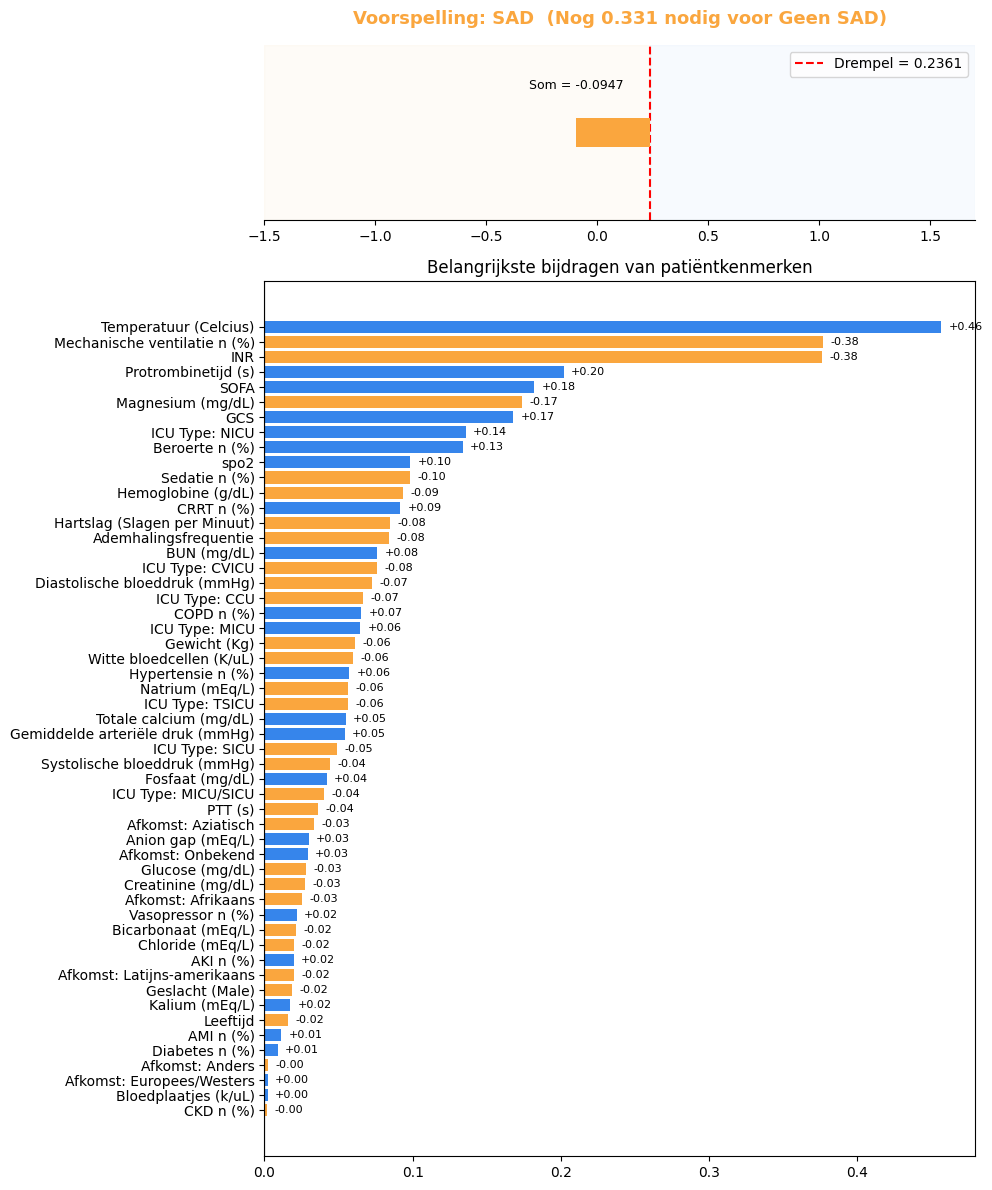

TypeError: explain_spline_output() got an unexpected keyword argument 'combined'

In [180]:
manual_forward_kan(model, patient1)

In [129]:
patient10 = test_data[10]
patient10

tensor([0.8706, 0.1474, 0.1935, 0.1852, 0.2889, 0.8600, 0.5615, 0.3372, 0.3795,
        0.0020, 0.4970, 0.1677, 0.0726, 0.0201, 0.1627, 0.4773, 0.5122, 0.1096,
        0.1538, 0.4692, 0.0479, 0.0330, 0.0370, 0.0862, 0.3696, 0.2391, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1333])

In [73]:
print(f"The prediction flips at: {x_flip}")

x_input = patient10

if x_input.dim() == 1:
        x_input = x_input.unsqueeze(0)

feature_names = original_data.columns.tolist()[:-1] # Do not include SAD
batch_size = x_input.shape[0]

# First Layer
layer1 = model.act_fun[0]
grid1, coef1, scale_base1, scale_sp1 = get_layer_components(layer1)

spline_out1 = compute_spline_outputs(x_input, grid1, coef1, model.k, splineplots=False, layer_idx=0)
base_out1 = layer1.base_fun(x_input)
combined1 = compute_combined_output(base_out1, spline_out1, scale_base1, scale_sp1)
layer1_out = combined1.sum(dim=1, keepdim=True)

# Compare Activation Output to threshold
diff = layer1_out.item() - x_flip
print(f"Layer 1 out is: {layer1_out.item()}")
print(f"The difference between prediction and flip is: {diff}")

The prediction flips at: 0.23608608543872833
Layer 1 out is: -0.3856411278247833
The difference between prediction and flip is: -0.6217272132635117


In [77]:
def explain_spline_cf(
    model, l, i, j, feature_min, feature_max,
    x_norm_val=None, diff=None, title=None, feature_names=None,
    save_dir=None
):
    x_norm = cached_preacts[l][:, j, i].detach().cpu().numpy()
    y_vals = cached_postacts[l][:, j, i].detach().cpu().numpy()

    x_real_vals = x_norm * (feature_max - feature_min) + feature_min
    sorted_idx = np.argsort(x_real_vals)
    x_real_vals = x_real_vals[sorted_idx]
    y_vals = y_vals[sorted_idx]

    feature_label = feature_names[i] if feature_names is not None and i < len(feature_names) else f"Feature {i}"

    # Check for crossing if diff is provided
    if x_norm_val is not None and diff is not None:
        x_real = x_norm_val * (feature_max - feature_min) + feature_min
        if np.min(x_real_vals) <= x_real <= np.max(x_real_vals):
            y_at_x_real = np.interp(x_real, x_real_vals, y_vals)
            target_y = y_at_x_real - diff

            # Check for crossings
            has_crossing = any(
                (y0 - target_y) * (y1 - target_y) <= 0 and y1 != y0
                for y0, y1 in zip(y_vals[:-1], y_vals[1:])
            )

            if not has_crossing:
                print(f"[SKIPPED] No crossing for {feature_label}: target_y = {target_y:.4f}")
                return
        else:
            print(f"[SKIPPED] x = {x_real:.2f} is outside the spline range.")
            return

    # Plotting
    blue = 'tab:blue'
    orange = 'tab:orange'

    plt.figure(figsize=(8, 5))
    plt.axhspan(0, max(y_vals.max(), 0), color='lightgray', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)

    for k in range(len(x_real_vals) - 1):
        x0, x1 = x_real_vals[k], x_real_vals[k + 1]
        y0, y1 = y_vals[k], y_vals[k + 1]

        if y0 >= 0 and y1 >= 0:
            plt.plot([x0, x1], [y0, y1], color=blue)
        elif y0 < 0 and y1 < 0:
            plt.plot([x0, x1], [y0, y1], color=orange)
        else:
            zero_x = x0 + (0 - y0) * (x1 - x0) / (y1 - y0)
            if y0 < 0:
                plt.plot([x0, zero_x], [y0, 0], color=orange)
                plt.plot([zero_x, x1], [0, y1], color=blue)
            else:
                plt.plot([x0, zero_x], [y0, 0], color=blue)
                plt.plot([zero_x, x1], [0, y1], color=orange)

    for x, y in zip(x_real_vals, y_vals):
        color = blue if y >= 0 else orange
        plt.plot(x, y, 'o', color=color, markersize=4)

    if x_norm_val is not None:
        x_real = x_norm_val * (feature_max - feature_min) + feature_min
        plt.axvline(x_real, color='red', linestyle='--', label=f'{feature_label} = {x_real:.2f}')
        if np.min(x_real_vals) <= x_real <= np.max(x_real_vals):
            y_at_x_real = np.interp(x_real, x_real_vals, y_vals)
            plt.plot(x_real, y_at_x_real, 'ro')
            plt.text(
                x_real, y_at_x_real,
                f"{y_at_x_real:.4f}",
                fontsize=9,
                ha='left',
                va='bottom',
                color='red',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white', alpha=0.7)
            )

            if diff is not None:
                target_y = y_at_x_real - diff
                plt.axhline(target_y, color='purple', linestyle=':', linewidth=1.5, label=f"Advies verandert bij y = {target_y:.4f}")

                # Mark and label crossing points
                for k in range(len(x_real_vals) - 1):
                    y0, y1 = y_vals[k], y_vals[k + 1]
                    if (y0 - target_y) * (y1 - target_y) <= 0 and y1 != y0:
                        x0, x1 = x_real_vals[k], x_real_vals[k + 1]
                        cross_x = x0 + (target_y - y0) * (x1 - x0) / (y1 - y0)
                        cross_x_norm = (cross_x - feature_min) / (feature_max - feature_min)
                        plt.plot(cross_x, target_y, 'mo')
                        plt.text(
                            cross_x, target_y,
                            f"{cross_x:.2f}",
                            fontsize=8,
                            ha='center',
                            va='bottom',
                            color='purple',
                            bbox=dict(boxstyle="round,pad=0.2", edgecolor='purple', facecolor='white', alpha=0.6)
                        )
                        print(f"[CROSSING] {feature_label} ≈ {cross_x:.4f} [{cross_x_norm:.4f} normalized] gives output ≈ {target_y:.4f}")


    plt.xlabel(f"{feature_label}")
    plt.ylabel("Activation output")
    plt.title(title or f"Invloed van {feature_label} op het advies")
    plt.legend()
    plt.grid(True)

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        filename = f"layer{l}_input{i}_to_output{j}.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, bbox_inches='tight')
        print(f"Saved plot to {filepath}")

    plt.show()


[SKIPPED] No crossing for Leeftijd: target_y = 0.4660
[SKIPPED] No crossing for Gewicht (Kg): target_y = 0.5544
[CROSSING] Temperatuur (Celcius) ≈ 34.5092 [0.3641 normalized] gives output ≈ 0.2929
[CROSSING] Temperatuur (Celcius) ≈ 37.2230 [0.5945 normalized] gives output ≈ 0.2929
[CROSSING] Temperatuur (Celcius) ≈ 39.7801 [0.8116 normalized] gives output ≈ 0.2929
Saved plot to static/cf_splines\layer0_input2_to_output0.png


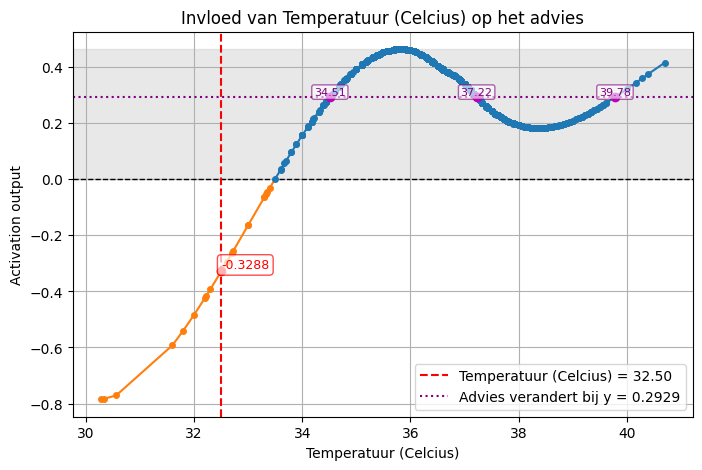

[SKIPPED] No crossing for Hartslag (Slagen per Minuut): target_y = 0.6410
[SKIPPED] No crossing for Ademhalingsfrequentie: target_y = 0.5961
[SKIPPED] No crossing for spo2: target_y = 0.7377
[SKIPPED] No crossing for Systolische bloeddruk (mmHg): target_y = 0.6349
[SKIPPED] No crossing for Diastolische bloeddruk (mmHg): target_y = 0.5354
[SKIPPED] No crossing for Gemiddelde arteriële druk (mmHg): target_y = 0.6740
[SKIPPED] No crossing for Witte bloedcellen (K/uL): target_y = 0.6529
[SKIPPED] No crossing for Hemoglobine (g/dL): target_y = 0.5728
[SKIPPED] No crossing for Bloedplaatjes (k/uL): target_y = 0.5853
[SKIPPED] No crossing for BUN (mg/dL): target_y = 0.6531
[SKIPPED] No crossing for Creatinine (mg/dL): target_y = 0.5707
[SKIPPED] No crossing for Glucose (mg/dL): target_y = 0.5964
[SKIPPED] No crossing for Natrium (mEq/L): target_y = 0.7638
[SKIPPED] No crossing for Chloride (mEq/L): target_y = 0.6778
[SKIPPED] No crossing for Kalium (mEq/L): target_y = 0.5763
[SKIPPED] No cros

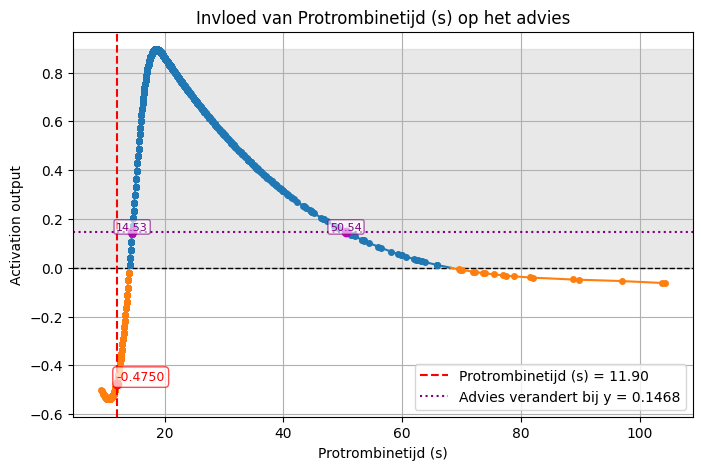

[SKIPPED] No crossing for PTT (s): target_y = 0.5604
[SKIPPED] No crossing for Bicarbonaat (mEq/L): target_y = 0.6319
[SKIPPED] No crossing for Anion gap (mEq/L): target_y = 0.6422
[SKIPPED] No crossing for Geslacht (Male): target_y = 0.6031
[SKIPPED] No crossing for Mechanische ventilatie n (%): target_y = 0.2449
[SKIPPED] No crossing for CRRT n (%): target_y = 0.7132
[SKIPPED] No crossing for Vasopressor n (%): target_y = 0.5268
[SKIPPED] No crossing for Sedatie n (%): target_y = 0.6856
[SKIPPED] No crossing for AMI n (%): target_y = 0.6332
[SKIPPED] No crossing for CKD n (%): target_y = 0.6198
[SKIPPED] No crossing for COPD n (%): target_y = 0.6872
[SKIPPED] No crossing for Hypertensie n (%): target_y = 0.6789
[SKIPPED] No crossing for Diabetes n (%): target_y = 0.6307
[SKIPPED] No crossing for AKI n (%): target_y = 0.6415
[SKIPPED] No crossing for Beroerte n (%): target_y = 0.7555
[SKIPPED] No crossing for Afkomst: Aziatisch: target_y = 0.5886
[SKIPPED] No crossing for Afkomst: Afr

In [78]:
# Loop through features and generate/save plots
for f_index in range(len(original_data.columns.tolist()) - 1):
    f_min, f_max = feature_bounds[f_index]
    x_norm_val = patient10[f_index].item()

    explain_spline_cf(
        model, 0, f_index, 0, f_min, f_max,
        x_norm_val=x_norm_val, diff=diff, title=None, feature_names=original_data.columns.tolist(),
        save_dir='static/cf_splines'
    )

In [130]:
patient10 = test_data[10].clone()
patient10_adopted = patient10.clone()
patient10_adopted[2] = 0.3641

In [132]:
patient10_adopted

tensor([0.8706, 0.1474, 0.3641, 0.1852, 0.2889, 0.8600, 0.5615, 0.3372, 0.3795,
        0.0020, 0.4970, 0.1677, 0.0726, 0.0201, 0.1627, 0.4773, 0.5122, 0.1096,
        0.1538, 0.4692, 0.0479, 0.0330, 0.0370, 0.0862, 0.3696, 0.2391, 1.0000,
        1.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.1333])

In [125]:
full_true_tensor = denormalize_instance(
        patient10_adopted,
        scaler,
        ordinal_encoder,
        continuous_indices,
        ordinal_indices,
        binary_indices
    )

In [126]:
full_true_tensor

tensor([ 92.0000,  60.0000,  32.4994,  56.0000,  18.0000,  93.0000, 147.0000,
         78.0000,  94.0000,   0.3000,  11.5000, 171.0000,  18.0000,   0.4000,
        157.0000, 137.0000, 106.0000,   2.5000,   1.5000,   8.1000,   1.1000,
          1.1000,  11.9000,  28.1000,  20.0000,  14.0000,   1.0000,   1.0000,
          0.0000,   1.0000,   1.0000,   0.0000,   0.0000,   0.0000,   1.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,  15.0000,   4.0000])


Detailed computation for patient:

Protrombinetijd (s) = -0.0482 * 0.0146 + 1.2411 * -0.4267 = -0.5303
INR = 0.0694 * 0.0111 + 1.2043 * 0.3659 = 0.4414
Temperatuur (Celcius) = 0.3142 * 0.3723 + 1.3854 * 0.1520 = 0.3275
Mechanische ventilatie n (%) = -0.2521 * 0.0000 + 0.8628 * 0.2335 = 0.2015
GCS = -0.0735 * 0.7311 + 1.1518 * 0.1924 = 0.1678
SOFA = 0.0118 * 0.0344 + 1.0322 * 0.1532 = 0.1585
ICU Type: NICU = -0.1018 * 0.0000 + 0.9766 * 0.1389 = 0.1357
Beroerte n (%) = -0.1335 * 0.0000 + 0.9812 * 0.1363 = 0.1337
Magnesium (mg/dL) = 0.1518 * 0.1286 + 1.0482 * -0.1385 = -0.1256
AKI n (%) = -0.1594 * 0.7311 + 0.8175 * -0.0040 = -0.1198
Natrium (mEq/L) = -0.2407 * 0.3112 + 0.9280 * 0.1983 = 0.1092
spo2 = 0.1922 * 0.5178 + 0.9675 * 0.0083 = 0.1075
Creatinine (mg/dL) = 0.2317 * 0.0051 + 0.9504 * -0.1128 = -0.1060
Sedatie n (%) = -0.0135 * 0.0000 + 0.9609 * -0.1021 = -0.0981
Vasopressor n (%) = -0.0962 * 0.7311 + 0.9403 * -0.0262 = -0.0949
CRRT n (%) = 0.0478 * 0.0000 + 0.9950 * 0.0919 = 0.091

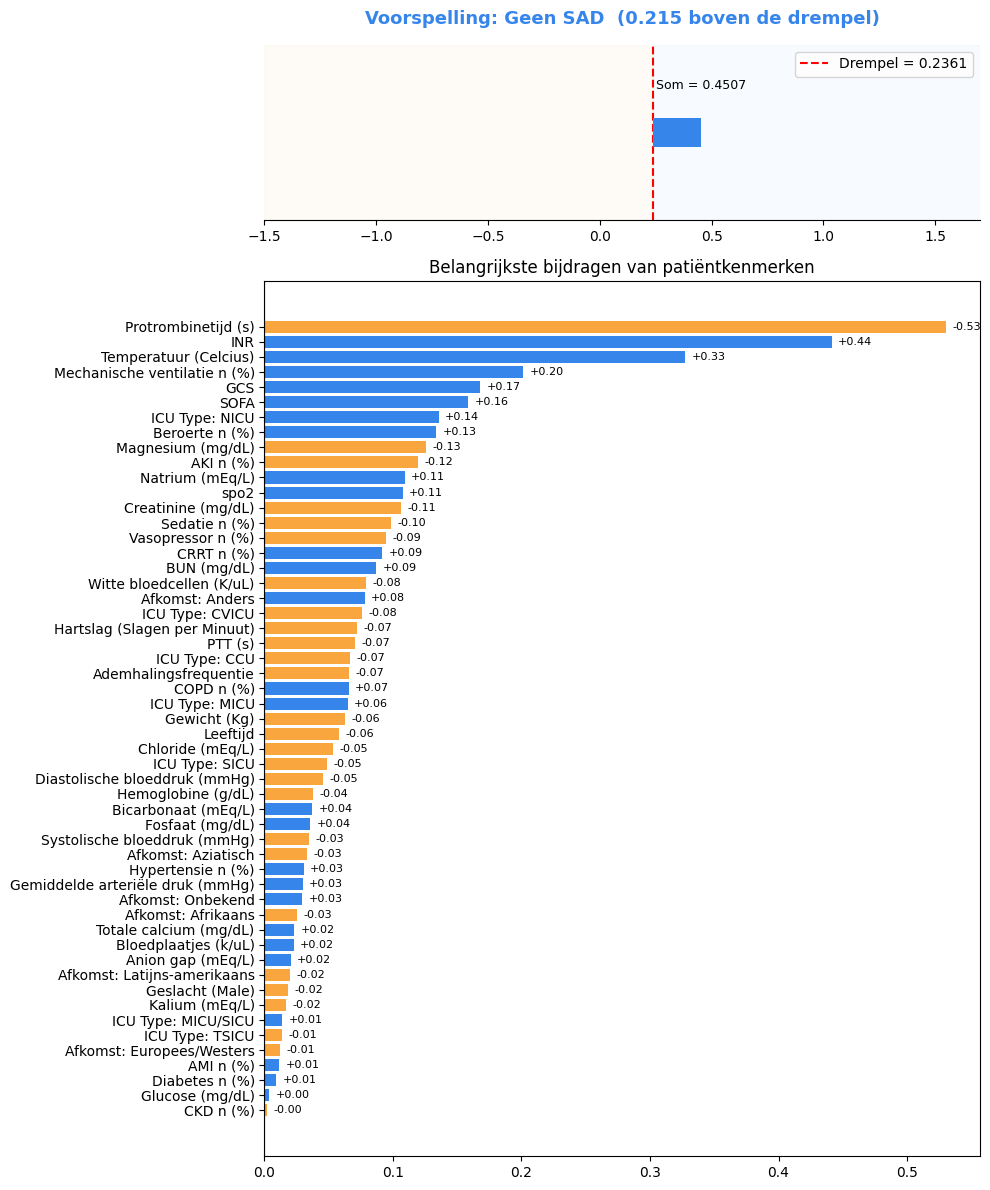

Grafiek opgeslagen als: static/local_splines\layer1_input0_adviesuitkomst.png
Grafiek opgeslagen als: static/local_splines\layer1_input0_adviesuitkomst.png
Final output: tensor([[ 0.5096, -0.2560]], grad_fn=<AddBackward0>)
Prediction: 0


(tensor([[ 0.5096, -0.2560]], grad_fn=<AddBackward0>), 0)

In [186]:
manual_forward_kan(model, patient2, detailed_computation=True)

In [ ]:
# Find the summed activations at which the prediction flips
# Evaluate the current summed activations value
# Look at the difference
# See for each feature if it is possible to go up or down 